In [5]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train[:30000]
x_test = x_test[:30000]

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

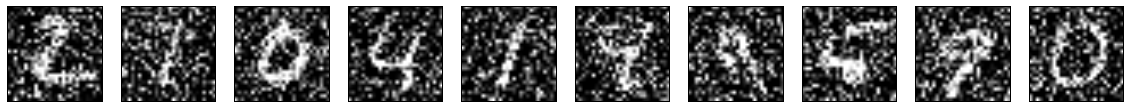

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
num_filters = 32
kernel_x = 3
kernel_y = kernel_x
pooling_factors = (2,2)

In [20]:
input_img = Input(shape=(1, 28, 28), name='Input image')

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #1')(input_img)
x = MaxPooling2D(pooling_factors, border_mode='same', name='Pooling layer #1')(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #2')(x)
#x = MaxPooling2D(pooling_factors, border_mode='same')(x)
#x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D(pooling_factors, border_mode='same', name='Encoding pooling layer')(x)

# at this point the representation is (32, 7, 7)
# EACH FILTER ADDS A DIMENSION!!!!

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #1')(encoded)
x = UpSampling2D(pooling_factors, name='Upsampling layer #1')(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #2')(x)
x = UpSampling2D(pooling_factors, name='Upsampling layer #2')(x)
#x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same')(x)
#x = UpSampling2D(pooling_factors)(x)
decoded = Convolution2D(1, kernel_x, kernel_y, activation='sigmoid', border_mode='same', name='Piece-together conv layer')(x)
# THE NUMBER OF KERNELS HERE IS 1 BECAUSE THAT WAY IT OUTPUTS A SINGLE DIMENSION (CHANNEL)

autoencoder = Model(input=input_img, output= decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [38]:
num_epoch = 3
batch_size = 64
from keras import callbacks
remote = callbacks.RemoteMonitor(root='http://localhost:9000')

In [ ]:
train = autoencoder.fit(x_train_noisy, x_train,
                nb_epoch=num_epoch,
                batch_size=batch_size,
                validation_data=(x_test_noisy, x_test),
                callbacks=[remote])

Train on 30000 samples, validate on 10000 samples
Epoch 1/3
10688/30000 [=========>....................] - ETA: 97s - loss: 0.1166

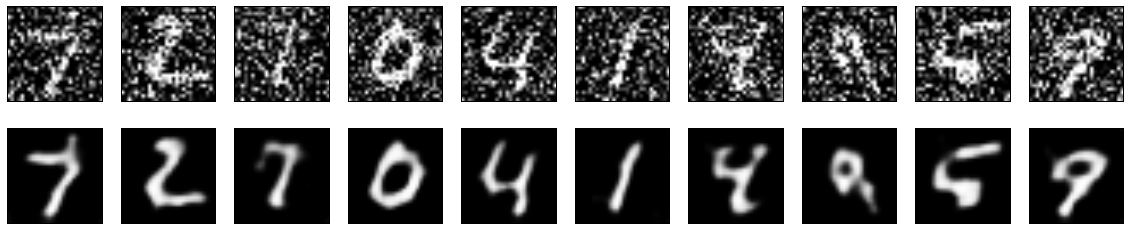

In [13]:
decoded_imgs = autoencoder.predict(x_test_noisy[:10])
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

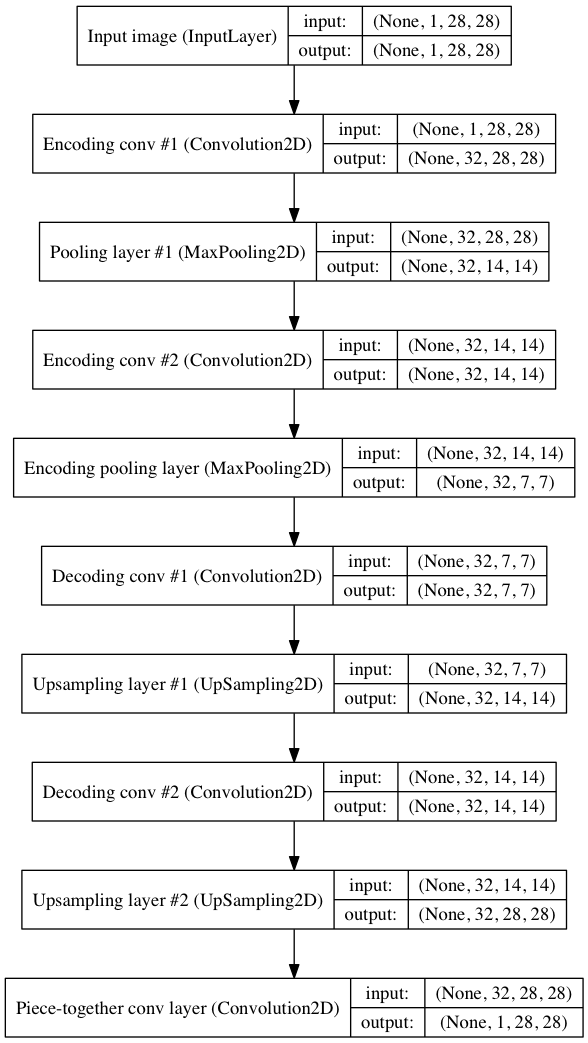

In [34]:
from IPython.display import SVG, Image
from keras.utils.visualize_util import model_to_dot, plot

# SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
plot(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename="autoencoder.png")